In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import median_absolute_error
# from sklearn.metrics import mean_squared_error
from math import sqrt
# from xgboost import XGBRegressor
from sklearn.externals import joblib
import copy 
import pickle
import os
from pprint import pprint
import math
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
listings_file_path ='C:\\Users\\xiao\\Documents\\listings.csv' 
listings = pd.read_csv(listings_file_path)
reviews=pd.read_csv('C:\\Users\\xiao\\Documents\\reviews.csv.gz')

c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [4]:
reviews.comments.fillna('none',inplace=True)

In [5]:
reviews[reviews.comments.str.contains('super host',case=False)==True].shape

(2638, 6)

In [6]:
reviews[reviews.comments.str.contains('superhost',case=False)==True].shape

(1127, 6)

In [7]:
reviews.comments = reviews.comments.str.replace("superhost","",regex=True, case=False)
reviews.comments = reviews.comments.str.replace("super host","",regex=True, case=False)

In [8]:
reviews=reviews.groupby(['listing_id'])['comments'].apply(','.join).reset_index()

In [9]:
reviews.head(5)

,listing_id,comments
0,2595,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,3831,"lisa is a wonderful, kind and thoughtful host...."
2,5121,"Simple place, super nice guy.,Great guy with a..."
3,5136,My family had a wonderful stay at Rebecca and ...
4,5178,"MR. Kasai was a grreat host , very helpful and..."


## deal with data in listings

In [10]:
df_combined=pd.merge(listings, reviews, left_on='id', right_on='listing_id', how='left')

In [11]:
df_combined['host_is_superhost'].fillna('f', inplace = True)
df_combined.replace({'host_is_superhost': {'t': True, 'f': False}},inplace=True)
df_combined=df_combined[df_combined.comments.isnull()==False]
df_combined.shape

(28501, 76)

In [12]:
df_combined.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [13]:
final_data =copy.deepcopy(df_combined)

In [14]:
useless = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary','description', 
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_thumbnail_url',
       'host_picture_url',
       'city', 'state', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'weekly_price', 'monthly_price','calendar_last_scraped','license','calendar_updated','id']

remained = list(set(list(final_data.columns))-set(useless))
final_data = final_data[remained]

In [15]:
final_data['price'] = final_data['price'].str.replace('\$|,', '')
final_data['price'] = pd.to_numeric(final_data['price'])
final_data['bathrooms'] = final_data['bathrooms_text'].str.extract('(\d+\.?\d*)')
final_data['bathrooms'] = pd.to_numeric(final_data['bathrooms'])
useless = ['bathrooms_text','minimum_nights','longitude','latitude','beds','calculated_host_listings_count', 
           'availability_30', 'availability_60', 'availability_90','room_type','maximum_minimum_nights','minimum_maximum_nights','minimum_minimum_nights','maximum_maximum_nights',
          'property_type','amenities']
final_data.drop(useless, axis=1,inplace=True)

In [16]:
final_data.columns

Index(['neighborhood_overview', 'host_about', 'review_scores_value',
       'number_of_reviews_l30d', 'last_review', 'bathrooms',
       'review_scores_communication', 'maximum_nights',
       'neighbourhood_group_cleansed', 'host_is_superhost', 'price',
       'host_has_profile_pic', 'calculated_host_listings_count_entire_homes',
       'review_scores_cleanliness', 'host_total_listings_count',
       'host_verifications', 'host_acceptance_rate',
       'calculated_host_listings_count_private_rooms', 'bedrooms',
       'maximum_nights_avg_ntm', 'neighbourhood', 'host_identity_verified',
       'has_availability', 'host_response_rate', 'review_scores_rating',
       'host_neighbourhood', 'availability_365', 'instant_bookable',
       'host_response_time', 'first_review', 'reviews_per_month', 'comments',
       'calculated_host_listings_count_shared_rooms', 'host_listings_count',
       'number_of_reviews_ltm', 'review_scores_checkin', 'listing_id',
       'neighbourhood_cleansed', 'mini

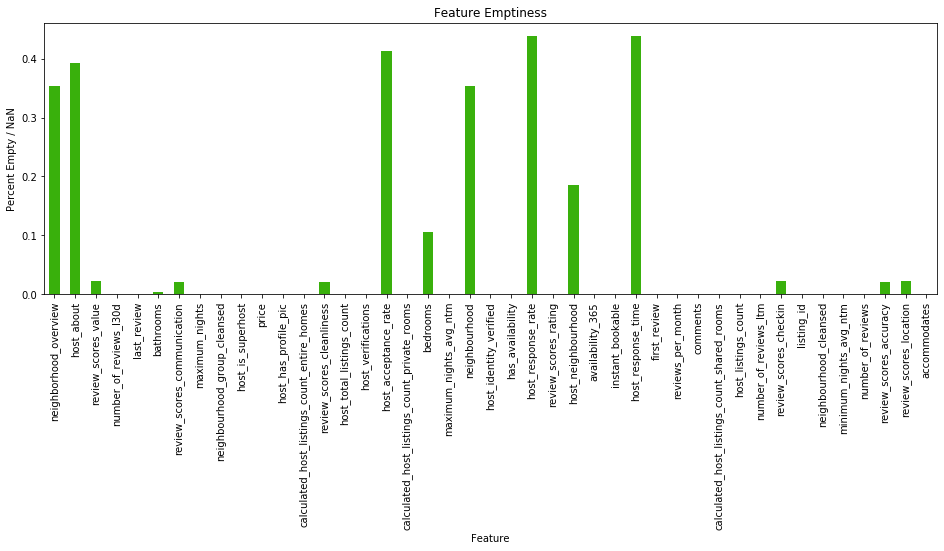

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

percentage_missing_data = final_data.isnull().sum() / final_data.shape[0]
ax = percentage_missing_data.plot(kind = 'bar', color='#39B00C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
plt.show()

In [18]:
kick_1 = ['bathrooms','neighborhood_overview','host_response_rate','host_about',
          'host_response_time','host_acceptance_rate','neighbourhood','host_neighbourhood']
final_data.drop(kick_1,axis=1,inplace=True)

In [19]:
final_data.dtypes

review_scores_value                             float64
number_of_reviews_l30d                            int64
last_review                                      object
review_scores_communication                     float64
maximum_nights                                    int64
neighbourhood_group_cleansed                     object
host_is_superhost                                  bool
price                                           float64
host_has_profile_pic                             object
calculated_host_listings_count_entire_homes       int64
review_scores_cleanliness                       float64
host_total_listings_count                       float64
host_verifications                               object
calculated_host_listings_count_private_rooms      int64
bedrooms                                        float64
maximum_nights_avg_ntm                          float64
host_identity_verified                           object
has_availability                                

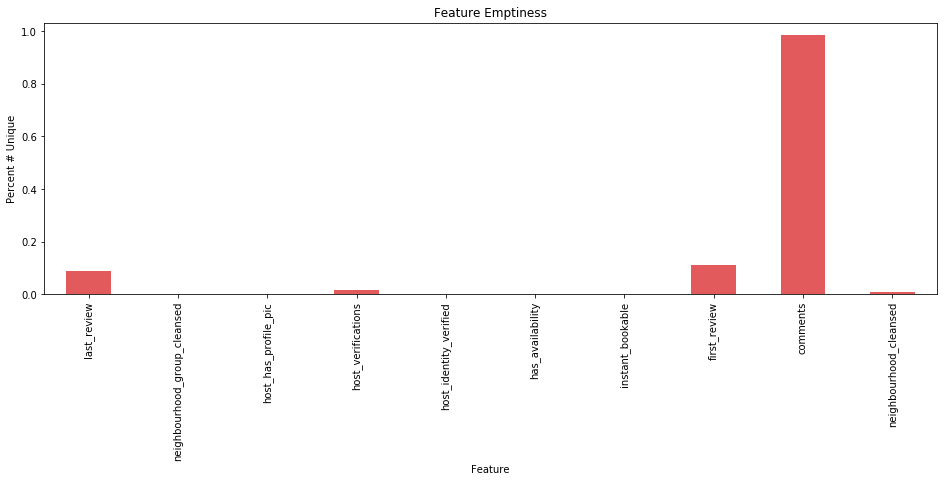

In [20]:
categories = final_data.columns[final_data.dtypes == 'object']
percentage_unique = final_data[categories].nunique() / final_data.shape[0]

ax = percentage_unique.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent # Unique')
ax.set_title('Feature Emptiness')
plt.show()

In [21]:
final_data.drop(['first_review','last_review'],axis=1,inplace=True)

In [22]:
final_data.shape

(28501, 33)

In [23]:
final_data.dropna(axis=0,how='any').shape

(24912, 33)

In [24]:
# final_data.to_csv('host_data_NYC_11_30.csv',index=False)